In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import time
import selenium
import pandas as pd
import numpy as np
import sqlite3
import sqlalchemy
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans



In [ ]:


def obtener_enlaces(url_base, archivo_csv, max_paginas=None):
    enlaces_productos = []
    pagina = 1

    while max_paginas is None or pagina <= max_paginas:
        url = f"{url_base}{pagina}"
        print(f'Accediendo a: {url}')

        try:
            response = requests.get(url)
            response.raise_for_status()
            
        except requests.RequestException as e:
         print(f"Error al acceder a {url}: {e}")
         break

        soup = BeautifulSoup(response.text, 'html.parser')
        productos = soup.find_all('div', class_='product-card')
        for producto in productos:
            anchor = producto.find('a', class_='product-card-image-link not-logged')
            if anchor:
                enlace = anchor['href']
                enlaces_productos.append(enlace)
        if not productos:
            break
        pagina += 1

    with open(archivo_csv, mode='w', newline='') as archivo:
        writer = csv.writer(archivo)
        writer.writerow(['enlace'])  # Escribe la cabecera
        for enlace in enlaces_productos:
            writer.writerow([enlace])
    print(f"Se guardaron {len(enlaces_productos)} enlaces en {archivo_csv}")

obtener_enlaces('https://www.jumbo.cl/frutas-y-verduras?page=', 'ejemplo.csv')

Buscamos los enlaces de todos los productos mediante su patrón: primero div, luego div y luego anchor con una clase particular, como el href siempre es relativo /producto1 , podemos concatenar con jumbo.cl/enlace

Ahora leemos todos los links y extraimos el valor nutricional

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv

# Necesitamos ahora manejar la paginación
base_url = 'https://jumbo.cl/bebidas-aguas-jugos?page='

enlaces_productos = []
enlaces_imagenes = []

# Paginación: supongamos que sabemos que hay un máximo de 10 páginas, o podrías usar un loop while para explorar hasta que ya no haya más productos.
pagina = 1
while True:
    # Concatenar el número de página a la URL base
    url = f'{base_url}{pagina}'
    print(f'Accediendo a: {url}')
    
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Buscar los divs que contienen los productos
    productos = soup.find_all('div', class_='product-card')  # Ajustar la clase si es necesario
    
    # Si no se encuentran productos, romper el loop
    if not productos:
        print(f"No se encontraron productos en la página {pagina}. Terminando paginación.")
        break

    # Extraer los enlaces de producto e imágenes
    for producto in productos:
        # Extraer el enlace del producto
        anchor = producto.find('a', class_='product-card-image-link not-logged')
        if anchor:
            enlace = anchor['href']
            enlaces_productos.append(enlace)

        # Extraer la imagen del producto
        imagen = producto.find('img', class_='lazy-image')  # Ajustar si es necesario
        if imagen:
            enlace_imagen = imagen['src']
            enlaces_imagenes.append(enlace_imagen)
        else:
            enlaces_imagenes.append(None)  # Manejar el caso donde no haya imagen

    # Ir a la siguiente página
    pagina += 1

# Guardar los enlaces de productos e imágenes en un CSV
with open('enlaces_productos_imagenes.csv', mode='w', newline='') as archivo_csv:
    writer = csv.writer(archivo_csv)
    writer.writerow(['enlace_producto', 'enlace_imagen'])  # Cabecera del archivo CSV
    for enlace_producto, enlace_imagen in zip(enlaces_productos, enlaces_imagenes):
        writer.writerow([enlace_producto, enlace_imagen])

print("Enlaces de productos e imágenes guardados en 'enlaces_productos_imagenes.csv'.")


In [ ]:
import json
import csv
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time


# Configuración de las opciones de Chrome

def scraping_data(archivo_csv, archivo_resultante, driver_path, limite=len(archivo_csv)):
    options = Options()
    options.binary_location = r'C:\Program Files\BraveSoftware\Brave-Browser\Application\brave.exe'
    service = Service(r"C:\Users\SIMON\Desktop\Kaggle\scraping\chromedriver.exe")
    driver = webdriver.Chrome(service=service, options=options)
# Leer enlaces desde el archivo CSV, ignorando el carácter ';'
    with open(archivo_csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file, delimiter=',')  # Usa la coma como delimitador
    enlaces = [row[0].strip().replace(';', '') for row in reader if row]  # Limpiar espacios y eliminar ';'
# Limitar a los primeros 10 enlaces
    enlaces = enlaces[:10]

# Lista para almacenar los datos nutricionales
    datos_nutricionales = []

# Procesar cada enlace
    for enlace in enlaces:
        url_producto = f'https://www.jumbo.cl{enlace}'  # Construir la URL del producto
        print(f'Accediendo a: {url_producto}')
    
    try:
        driver.get(url_producto)
        time.sleep(2)  # Espera a que la página cargue

        # Extraer el H1
        h1_element = driver.find_element(By.CSS_SELECTOR, 'h1.product-name.text-black.text-lg.font-bold.lg\\:text-2xl.lg\\:mb-0\\.5')
        marca = driver.find_element(By.CSS_SELECTOR, 'span.product-brand.leading-\\[18px\\].text-primary500.text-base.font-semibold.text-black-600.underline.capitalize')
        marca_producto = marca.text.strip()
        nombre_producto = h1_element.text.strip()
        id_product = driver.find_element(By.CSS_SELECTOR, 'span.product-code.text-greyMidDark.text-sm.lg\\:mb-2')
        codigo_producto = id_product.text.strip()  # Obtener el id
        precio = driver.find_element(By.CSS_SELECTOR, 'span.prices-main-price')
        precio = precio.text.strip()  # Obtener el precio del producto
        # Hacer clic en la pestaña de "Información nutricional"
        informacion_nutricional_tab = driver.find_element(By.XPATH, "//span[contains(text(), 'Información nutricional')]")
        driver.execute_script("arguments[0].scrollIntoView();", informacion_nutricional_tab)
        informacion_nutricional_tab.click()
        
        

        time.sleep(2)  # Espera a que se cargue la tabla

        # Encuentra todos los <li> dentro de los <ul> que tienen la clase 'nutritional-details-container-data'
        li_elements = driver.find_elements(By.CSS_SELECTOR, 'ul.nutritional-details-container-data li')

        # Verificar cuántos <li> se encontraron
        print(f'Total de <li> encontrados: {len(li_elements)}')

        # Crear un diccionario para almacenar los nutrientes del producto
        producto_info = {
            'Marca': marca_producto,
            'Codigo Producto': codigo_producto,
            'Nombre Producto': nombre_producto,
            'Precio': precio,
            'Nutrientes': []  # Lista para almacenar los nutrientes
        }

        # Procesar los elementos, asumiendo que la estructura es nutriente seguido de dos valores
        for i in range(0, len(li_elements), 3):  # Incrementar de 3 en 3
            if i + 2 < len(li_elements):  # Asegurarse de que hay suficiente para evitar errores de índice
                nutriente = li_elements[i].text.strip()  # Nombre del nutriente
                valor_por_100g = li_elements[i + 1].text.strip()  # Valor por cada 100g
                valor_por_porcion = li_elements[i + 2].text.strip()  # Valor por porción
                print(f'Nutriente: {nutriente}, Valor por 100g: {valor_por_100g}, Valor por porción: {valor_por_porcion}')
                
                # Añadir el nutriente a la lista dentro del diccionario del producto
                producto_info['Nutrientes'].append({
                    'Nutriente': nutriente,
                    'Valor por 100g': valor_por_100g,
                    'Valor por porción': valor_por_porcion
                })
            else:
                print(f'Elemento sin suficientes valores encontrado: {li_elements[i].text.strip()}')

        # Añadir el diccionario del producto a la lista de datos
    except Exception as e:
        print(f"Error al procesar {url_producto}: {str(e)}")

    try:
        ingredientes_tab = driver.find_element(By.XPATH, "//span[contains(text(), 'Ingredientes')]")
        ingredientes_tab.click()
        time.sleep(1)  # Espera breve para asegurar que el contenido se carga

    # Extrae el contenido del div correspondiente a los ingredientes
        ingredientes_div = driver.find_element(By.CSS_SELECTOR, 'div.text-base.leading-5')
        ingredientes_texto = ingredientes_div.text.strip()

    # Agrega los ingredientes al diccionario del producto
        producto_info['Ingredientes'] = ingredientes_texto
        print(f'Ingredientes: {ingredientes_texto}')

    except:
    # Si no se encuentra la pestaña "Ingredientes", simplemente continúas sin agregarla
        print("No se encontró la pestaña de 'Ingredientes' para este producto.")
    datos_nutricionales.append(producto_info)
# Comprobar si se capturaron datos antes de guardar
if datos_nutricionales:
    # Guardar los datos en un archivo JSON
    nombre_archivo_json = 'datos_nutricionales.json'
    with open(nombre_archivo_json, 'w', encoding='utf-8') as file:
        json.dump(datos_nutricionales, file, ensure_ascii=False, indent=4)

    print(f"Datos guardados en {nombre_archivo_json}")

    # También puedes guardar en CSV si lo deseas
    # Ten en cuenta que el formato del CSV será diferente debido a la estructura
    nombre_archivo_csv = 'datos_nutricionales.csv'
    with open(nombre_archivo_csv, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['Codigo Producto', 'Nombre Producto', 'Nutriente', 'Valor por 100g', 'Valor por porción']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for producto in datos_nutricionales:
            for nutriente in producto['Nutrientes']:
                writer.writerow({
                    'Codigo Producto': producto['Codigo Producto'],
                    'Nombre Producto': producto['Nombre Producto'],
                    'Nutriente': nutriente['Nutriente'],
                    'Valor por 100g': nutriente['Valor por 100g'],
                    'Valor por porción': nutriente['Valor por porción']
                })

    print(f"Datos guardados en {nombre_archivo_csv}")
else:
    print("No se encontraron datos nutricionales.")

# Cerrar el driver después de terminar
driver.quit()

# Cargar y mostrar el DataFrame
df = pd.read_json('datos_nutricionales.json')



In [ ]:
import csv
import json
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options


def scraping_data(lista_csvs, driver_path, archivo_resultante_base):
    """
    Realiza scraping de datos desde una lista de archivos CSV y genera un archivo JSON por cada archivo.
    """
    # Configuración del driver
    options = Options()
    options.binary_location = r'C:\Program Files\BraveSoftware\Brave-Browser\Application\brave.exe'
    service = Service(driver_path)
    driver = webdriver.Chrome(service=service, options=options)

    for archivo_csv in lista_csvs:
        # Preguntar al usuario por el tipo de producto
        tipo_producto = input(f"Ingrese el tipo de producto para los enlaces en {archivo_csv}: ").strip()

        # Leer enlaces desde el archivo CSV
        with open(archivo_csv, 'r', encoding='utf-8') as file:
            reader = csv.reader(file)
            enlaces = [row[0].strip() for row in reader if row]

        # Lista para almacenar los datos nutricionales
        datos_nutricionales = []

        # Procesar cada enlace
        for enlace in enlaces:
            url_producto = f'https://www.jumbo.cl{enlace}'  # Construir la URL del producto
            print(f'Accediendo a: {url_producto}')

            try:
                driver.get(url_producto)
                time.sleep(2)  # Espera a que la página cargue

                # Extraer datos del producto
                h1_element = driver.find_element(By.CSS_SELECTOR, 
                                                 'h1.product-name.text-black.text-lg.font-bold.lg\\:text-2xl.lg\\:mb-0\\.5')
                marca = driver.find_element(By.CSS_SELECTOR, 
                                            'span.product-brand.leading-\\[18px\\].text-primary500.text-base.font-semibold.text-black-600.underline.capitalize')
                id_product = driver.find_element(By.CSS_SELECTOR, 
                                                 'span.product-code.text-greyMidDark.text-sm.lg\\:mb-2')
                precio = driver.find_element(By.CSS_SELECTOR, 'span.prices-main-price')

                marca_producto = marca.text.strip()
                nombre_producto = h1_element.text.strip()
                codigo_producto = id_product.text.strip()  # Obtener el id
                precio_producto = precio.text.strip()  # Obtener el precio del producto

                # Información nutricional
                nutrientes = []
                try:
                    informacion_nutricional_tab = driver.find_element(By.XPATH, "//span[contains(text(), 'Información nutricional')]")
                    driver.execute_script("arguments[0].scrollIntoView();", informacion_nutricional_tab)
                    informacion_nutricional_tab.click()
                    time.sleep(2)  # Espera a que se cargue la tabla

                    li_elements = driver.find_elements(By.CSS_SELECTOR, 'ul.nutritional-details-container-data li')

                    for i in range(0, len(li_elements), 3):  # Incrementar de 3 en 3
                        if i + 2 < len(li_elements):
                            nutriente = li_elements[i].text.strip()
                            valor_por_100g = li_elements[i + 1].text.strip()
                            valor_por_porcion = li_elements[i + 2].text.strip()

                            nutrientes.append({
                                'Nutriente': nutriente,
                                'Valor por 100g': valor_por_100g,
                                'Valor por porción': valor_por_porcion
                            })
                except Exception as e:
                    print(f"Información nutricional no disponible: {e}")

                # Ingredientes
                ingredientes_texto = "No disponible"
                try:
                    ingredientes_tab = driver.find_element(By.XPATH, "//span[contains(text(), 'Ingredientes')]")
                    ingredientes_tab.click()
                    time.sleep(1)

                    ingredientes_div = driver.find_element(By.CSS_SELECTOR, 'div.text-base.leading-5')
                    ingredientes_texto = ingredientes_div.text.strip()
                except Exception as e:
                    print(f"No se encontró la pestaña de 'Ingredientes': {e}")

                # Guardar datos del producto
                datos_nutricionales.append({
                    'Tipo Producto': tipo_producto,
                    'Marca': marca_producto,
                    'Nombre Producto': nombre_producto,
                    'Codigo Producto': codigo_producto,
                    'Precio': precio_producto,
                    'Ingredientes': ingredientes_texto,
                    'Nutrientes': nutrientes
                })

            except Exception as e:
                print(f"Error al procesar {url_producto}: {e}")

        # Guardar los datos en un archivo JSON
        archivo_json = f"{archivo_resultante_base}_{tipo_producto.replace(' ', '_')}.json"
        with open(archivo_json, 'w', encoding='utf-8') as file:
            json.dump(datos_nutricionales, file, ensure_ascii=False, indent=4)

        print(f"Datos guardados en {archivo_json}")

    # Cerrar el driver
    driver.quit()


In [64]:
import csv

# Leer el archivo CSV con los enlaces
enlaces = []
with open('enlaces_productos_imagenes.csv', mode='r') as archivo_csv:
    reader = csv.reader(archivo_csv)
    next(reader)  # Saltar la cabecera
    for row in reader:
        enlaces.append(row[0])  # Cada enlace es una fila

print("Enlaces leídos:", len(enlaces))


Enlaces leídos: 1998


In [ ]:

#Averiguar para qué escribí esto
with open('nutrientes.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["enlace", "Nutriente", "Tipo de Valor", "Valor"])

    # Asumiendo que 'valores' contiene los nutrientes
    for enlace, tipo_valor, valor in datos_nutricionales:
        if tipo_valor == "Valores Medios":
            # Añadir la línea para "Por cada 100 g/ml" y "Por cada 1 porción"
            writer.writerow([enlace, valor, "Valores Medios", ""])
        else:
            # Solo agrega el valor real aquí
            writer.writerow([enlace, "Nutriente", tipo_valor, valor])

print("Datos guardados en nutrientes.csv")

Datos guardados en nutrientes.csv


In [ ]:
import csv
import json
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options


def scraping_data(lista_csvs, driver_path, archivo_resultante_base):
    """
    Realiza scraping de datos desde una lista de archivos CSV y genera un archivo JSON por cada archivo.
    """
    # Configuración del driver
    options = Options()
    options.binary_location = r'C:\Program Files\BraveSoftware\Brave-Browser\Application\brave.exe'
    service = Service(driver_path)
    driver = webdriver.Chrome(service=service, options=options)

    for archivo_csv in lista_csvs:
        # Preguntar al usuario por el tipo de producto
        tipo_producto = input(f"Ingrese el tipo de producto para los enlaces en {archivo_csv}: ").strip()

        # Leer enlaces desde el archivo CSV
        with open(archivo_csv, 'r', encoding='utf-8') as file:
            reader = csv.reader(file)
            enlaces = [row[0].strip() for row in reader if row]

        # Lista para almacenar los datos nutricionales
        datos_nutricionales = []

        # Procesar cada enlace
        for enlace in enlaces:
            url_producto = f'https://www.jumbo.cl{enlace}'  # Construir la URL del producto
            print(f'Accediendo a: {url_producto}')

            try:
                driver.get(url_producto)
                time.sleep(2)  # Espera a que la página cargue

                # Extraer datos del producto
                nombre_producto = driver.find_element(By.CSS_SELECTOR, 'h1.product-name').text.strip()
                precio = driver.find_element(By.CSS_SELECTOR, 'span.prices-main-price').text.strip()
                codigo_producto = driver.find_element(By.CSS_SELECTOR, 'span.product-code').text.strip()

                # Información nutricional
                nutrientes = []
                try:
                    driver.find_element(By.XPATH, "//span[contains(text(), 'Información nutricional')]").click()
                    time.sleep(2)
                    li_elements = driver.find_elements(By.CSS_SELECTOR, 'ul.nutritional-details-container-data li')
                    for i in range(0, len(li_elements), 3):
                        if i + 2 < len(li_elements):
                            nutriente = li_elements[i].text.strip()
                            valor_por_100g = li_elements[i + 1].text.strip()
                            valor_por_porcion = li_elements[i + 2].text.strip()
                            nutrientes.append({
                                'Nutriente': nutriente,
                                'Valor por 100g': valor_por_100g,
                                'Valor por porción': valor_por_porcion
                            })
                except Exception as e:
                    print(f"Información nutricional no disponible: {e}")

                # Guardar datos del producto
                datos_nutricionales.append({
                    'Tipo Producto': tipo_producto,
                    'Nombre Producto': nombre_producto,
                    'Precio': precio,
                    'Codigo Producto': codigo_producto,
                    'Nutrientes': nutrientes
                })
            except Exception as e:
                print(f"Error al procesar {url_producto}: {e}")

        # Guardar los datos en un archivo JSON
        archivo_json = f"{archivo_resultante_base}_{tipo_producto.replace(' ', '_')}.json"
        with open(archivo_json, 'w', encoding='utf-8') as file:
            json.dump(datos_nutricionales, file, ensure_ascii=False, indent=4)

        print(f"Datos guardados en {archivo_json}")

    # Cerrar el driver
    driver.quit()


Una vez obtenido los datos, pasamos a formatearlos correctamente antes de hacer análisis estadístico


In [66]:
import json
import csv
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time

# Configuración de las opciones de Chrome
options = Options()
options.binary_location = r'C:\Program Files\BraveSoftware\Brave-Browser\Application\brave.exe'
service = Service(r"C:\Users\SIMON\Desktop\Kaggle\scraping\chromedriver.exe")

# Inicializa el driver
driver = webdriver.Chrome(service=service, options=options)

# Leer enlaces desde el archivo CSV, ignorando el carácter ';'
with open('enlaces_productos.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file, delimiter=',')  # Usa la coma como delimitador
    enlaces = [row[0].strip().replace(';', '') for row in reader if row]  # Limpiar espacios y eliminar ';'

# Limitar a los primeros 10 enlaces
enlaces = enlaces[:10]

# Lista para almacenar los datos nutricionales
datos_nutricionales = []

# Procesar cada enlace
for enlace in enlaces:
    url_producto = f'https://www.jumbo.cl{enlace}'  # Construir la URL del producto
    print(f'Accediendo a: {url_producto}')
    
    # Crear un diccionario para almacenar los nutrientes del producto
    producto_info = {
        'Marca': '',
        'Codigo Producto': '',
        'Nombre Producto': '',
        'Precio': '',
        'Nutrientes': [],  # Lista para almacenar los nutrientes
        'Ingredientes': ''  # Campo para almacenar los ingredientes
    }
    
    try:
        driver.get(url_producto)
        time.sleep(2)  # Espera a que la página cargue

        # Extraer el H1
        h1_element = driver.find_element(By.CSS_SELECTOR, 'h1.product-name.text-black.text-lg.font-bold.lg\\:text-2xl.lg\\:mb-0\\.5')
        marca = driver.find_element(By.CSS_SELECTOR, 'span.product-brand.leading-\\[18px\\].text-primary500.text-base.font-semibold.text-black-600.underline.capitalize')
        marca_producto = marca.text.strip()
        nombre_producto = h1_element.text.strip()
        id_product = driver.find_element(By.CSS_SELECTOR, 'span.product-code.text-greyMidDark.text-sm.lg\\:mb-2')
        codigo_producto = id_product.text.strip()  # Obtener el id
        precio = driver.find_element(By.CSS_SELECTOR, 'span.prices-main-price')
        precio = precio.text.strip()  # Obtener el precio del producto
        # Hacer clic en la pestaña de "Información nutricional"
        informacion_nutricional_tab = driver.find_element(By.XPATH, "//span[contains(text(), 'Información nutricional')]")
        driver.execute_script("arguments[0].scrollIntoView();", informacion_nutricional_tab)
        informacion_nutricional_tab.click()
        
        

        time.sleep(2)  # Espera a que se cargue la tabla

        # Encuentra todos los <li> dentro de los <ul> que tienen la clase 'nutritional-details-container-data'
        li_elements = driver.find_elements(By.CSS_SELECTOR, 'ul.nutritional-details-container-data li')

        # Verificar cuántos <li> se encontraron
        print(f'Total de <li> encontrados: {len(li_elements)}')

        # Actualizar el diccionario con la información del producto
        producto_info['Marca'] = marca_producto
        producto_info['Codigo Producto'] = codigo_producto
        producto_info['Nombre Producto'] = nombre_producto
        producto_info['Precio'] = precio

        # Procesar los elementos, asumiendo que la estructura es nutriente seguido de dos valores
        for i in range(0, len(li_elements), 3):  # Incrementar de 3 en 3
            if i + 2 < len(li_elements):  # Asegurarse de que hay suficiente para evitar errores de índice
                nutriente = li_elements[i].text.strip()  # Nombre del nutriente
                valor_por_100g = li_elements[i + 1].text.strip()  # Valor por cada 100g
                valor_por_porcion = li_elements[i + 2].text.strip()  # Valor por porción
                print(f'Nutriente: {nutriente}, Valor por 100g: {valor_por_100g}, Valor por porción: {valor_por_porcion}')
                
                # Añadir el nutriente a la lista dentro del diccionario del producto
                producto_info['Nutrientes'].append({
                    'Nutriente': nutriente,
                    'Valor por 100g': valor_por_100g,
                    'Valor por porción': valor_por_porcion
                })
            else:
                print(f'Elemento sin suficientes valores encontrado: {li_elements[i].text.strip()}')

        # Añadir el diccionario del producto a la lista de datos
    except Exception as e:
        print(f"Error al procesar {url_producto}: {str(e)}")

    try:
        ingredientes_tab = driver.find_element(By.XPATH, "//span[contains(text(), 'Ingredientes')]")
        ingredientes_tab.click()
        time.sleep(1)  # Espera breve para asegurar que el contenido se carga

        # Extrae el contenido del div correspondiente a los ingredientes
        ingredientes_div = driver.find_element(By.CSS_SELECTOR, 'div.text-base.leading-5')
        ingredientes_texto = ingredientes_div.text.strip()

        # Agrega los ingredientes al diccionario del producto
        producto_info['Ingredientes'] = ingredientes_texto
        print(f'Ingredientes: {ingredientes_texto}')

    except:
        # Si no se encuentra la pestaña "Ingredientes", simplemente continúas sin agregarla
        print("No se encontró la pestaña de 'Ingredientes' para este producto.")
    datos_nutricionales.append(producto_info)
# Comprobar si se capturaron datos antes de guardar
if datos_nutricionales:
    # Guardar los datos en un archivo JSON
    nombre_archivo_json = 'datos_nutricionalesss.json'
    with open(nombre_archivo_json, 'w', encoding='utf-8') as file:
        json.dump(datos_nutricionales, file, ensure_ascii=False, indent=4)

    print(f"Datos guardados en {nombre_archivo_json}")

    # También puedes guardar en CSV si lo deseas
    # Ten en cuenta que el formato del CSV será diferente debido a la estructura
    nombre_archivo_csv = 'datos_nutricionalesss.csv'
    with open(nombre_archivo_csv, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['Codigo Producto', 'Nombre Producto', 'Nutriente', 'Valor por 100g', 'Valor por porción']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for producto in datos_nutricionales:
            for nutriente in producto['Nutrientes']:
                writer.writerow({
                    'Codigo Producto': producto['Codigo Producto'],
                    'Nombre Producto': producto['Nombre Producto'],
                    'Nutriente': nutriente['Nutriente'],
                    'Valor por 100g': nutriente['Valor por 100g'],
                    'Valor por porción': nutriente['Valor por porción']
                })

    print(f"Datos guardados en {nombre_archivo_csv}")
else:
    print("No se encontraron datos nutricionales.")

# Cerrar el driver después de terminar
driver.quit()

# Cargar y mostrar el DataFrame
df = pd.read_json('datos_nutricionales.json')



Accediendo a: https://www.jumbo.cl/platano-granel/p
Error al procesar https://www.jumbo.cl/platano-granel/p: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//span[contains(text(), 'Información nutricional')]"}
  (Session info: chrome=131.0.6778.69); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6EBF6E1F5+2972373]
	(No symbol) [0x00007FF6EBC055F0]
	(No symbol) [0x00007FF6EBAA57FA]
	(No symbol) [0x00007FF6EBAF5A3E]
	(No symbol) [0x00007FF6EBAF5D2C]
	(No symbol) [0x00007FF6EBB3EAB7]
	(No symbol) [0x00007FF6EBB1BABF]
	(No symbol) [0x00007FF6EBB3B8CC]
	(No symbol) [0x00007FF6EBB1B823]
	(No symbol) [0x00007FF6EBAE75E8]
	(No symbol) [0x00007FF6EBAE8751]
	GetHandleVerifier [0x00007FF6EBF947BD+3129501]
	GetHandleVerifier [0x00007FF6EBFE4D00+3458528]
	GetHandleVerifier [0x00007FF6EBFDB05D+3418429]
	GetHandleVerifier [0x0000

In [ ]:
import pandas as pd
import json
import re

# Cargar el JSON en un DataFrame
with open('datos_nutricionales.json', 'r', encoding='latin1') as file:
    datos = json.load(file)


# Crear el DataFrame
df = pd.json_normalize(datos, 'Nutrientes', ['Marca','Codigo Producto','Nombre Producto', 'Precio', 'Ingredientes'], errors='ignore')

df.rename(columns={
    'Nutriente': 'Nutriente',
    'Valor por 100g': 'Valor por 100g',
    'Valor por porcion': 'Valor por porción'
}, inplace=True)

# Pivotar el DataFrame para obtener formato ancho
df_ancho2 = df.pivot_table(index=['Nombre Producto', 'Precio', 'Codigo Producto', 'Marca', 'Ingredientes'], 
                           columns='Nutriente', 
                           values=['Valor por 100g', 'Valor por porcion'], 
                           aggfunc='first')

# Aplanar las columnas multiíndice
df_ancho2.columns = [f'{nutriente} {valor}' for valor, nutriente in df_ancho2.columns]

# Resetear el índice
df_ancho2.reset_index(inplace=True)

# Mostrar el DataFrame final


df_ancho2.columns = df_ancho2.columns.str.strip().str.lower() 
df_ancho2.columns = df_ancho2.columns.str.replace(' ', '_')


# Diccionario de mapeo para abreviaturas en inglés
abbreviations = {
    'azúcares_totales_(g)_valor_por_100g': 'total_sugars_100g',
    'colesterol_(mg)_valor_por_100g': 'cholesterol_100g',
    'energía_(kcal)_valor_por_100g': 'energy_100g',
    'fibra_(g)_valor_por_100g': 'fiber_100g',
    'grasas_monoinsaturadas_(g)_valor_por_100g': 'mono_fats_100g',
    'grasas_poliinsaturadas_(g)_valor_por_100g': 'poly_fats_100g',
    'fibra_(g)_valor_por_porción': 'fiber_serving',
    'grasas_monoinsaturadas_(g)_valor_por_porción': 'mono_fats_serving',
    'grasas_poliinsaturadas_(g)_valor_por_porción': 'poly_fats_serving',
    'grasas_saturadas_(g)_valor_por_porción': 'sat_fats_serving',
    'grasas_totales_(g)_valor_por_porción': 'total_fats_serving',
    'grasas_trans_(g)_valor_por_porción': 'trans_fats_serving',
    'hidratos_de_carbono_disponibles_(g)_valor_por_porción': 'available_carbs_serving',
    'proteínas_(g)_valor_por_porción': 'proteins_serving',
    'sodio_(mg)_valor_por_porción': 'sodium_serving',
}


df_ancho2.rename(columns=abbreviations, inplace=True)

df_ancho2['tamaño'] = df_ancho2['nombre_producto'].str.extract(r'(\d+(?:\.\d+)?\s*[a-zA-Z]+)$')


def separate_size(size):
    match = re.match(r'(\d+(?:\.\d+)?)\s*(L|ml|g|kg|cc)', size)
    if match:
        value, unit = match.groups()
        return pd.Series([value, unit])  # Devolver como serie
    return pd.Series([None, None])  # Si no hay coincidencia

# Convert 'tamaño' column to string type
df_ancho2['tamaño'] = df_ancho2['tamaño'].astype(str)

# Aplicar la función y crear nuevas columnas para Valor y Unidad
df_ancho2[['valor', 'unidad']] = df_ancho2['tamaño'].apply(separate_size)

df_ancho2.drop(columns=['tamaño'], inplace=True)

df_ancho2['marca'] = df_ancho2['marca'].replace('Frutas Y Verduras Propias', 'Jumbo')
df_ancho2['precio'] = df_ancho2['precio'].str.replace('$', '', regex=False)
df_ancho2['precio'] = df_ancho2['precio'].str.replace('.', '', regex=False)
df_ancho2['precio'] = df_ancho2['precio'].replace('', '0').astype(int)  # Replace empty strings with '0' before converting to int
df_ancho2['codigo_producto'] = df_ancho2['codigo_producto'].str.replace('Código: ', '', regex=False)

df_ancho2.fillna(0, inplace=True)

cols_to_convert = [
    "total_sugars_100g", "cholesterol_100g", "energy_100g", "fiber_100g",
    "mono_fats_100g", "poly_fats_100g", "grasas_saturadas_(g)_valor_por_100g",
    "grasas_totales_(g)_valor_por_100g", "grasas_trans_(g)_valor_por_100g",
    "hidratos_de_carbono_disponibles_(g)_valor_por_100g", "proteínas_(g)_valor_por_100g",
    "sodio_(mg)_valor_por_100g", "azúcares_totales_(g)_valor_por_porción",
    "colesterol_(mg)_valor_por_porción", "energía_(kcal)_valor_por_porción",
    "fiber_serving", "mono_fats_serving", "poly_fats_serving", "sat_fats_serving",
    "total_fats_serving", "trans_fats_serving", "available_carbs_serving",
    "proteins_serving", "sodium_serving"
]

# Convertir cada columna a tipo float
# Verificar las columnas existentes en df_ancho2
existing_columns = df_ancho2.columns

# Filtrar cols_to_convert para incluir solo las columnas que existen en df_ancho2
cols_to_convert = [col for col in cols_to_convert if col in existing_columns]

for col in cols_to_convert:
    df_ancho2[col] = df_ancho2[col].astype(str).str.replace(r'[^\d]', '', regex=True)  
    df_ancho2[col] = pd.to_numeric(df_ancho2[col])  # Convierte a float

# Confirmar las conversiones


df_ancho2 = df_ancho2[df_ancho2['precio'] != 0]

df_ancho2 = df_ancho2.drop(index=[65, 66]).reset_index(drop=True)

# histograma para la columna 'precio'






In [ ]:
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(df_ancho2['nombre_producto_limpio'])

num_clusters = 5  # Define el número de categorías iniciales
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_ancho2['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Asignar nombres a los clusters (opcional)
for cluster in range(num_clusters):
    print(f"Cluster {cluster}:")
    print(df_ancho2[df_ancho2['cluster'] == cluster]['nombre_producto'].head(20))

In [ ]:
scraping = pd.read_csv('datos_limpios.csv')

scraping.drop_duplicates(subset=['codigo_producto'], inplace=True)


,nombre_producto,precio,codigo_producto,marca,ingredientes,tipo_producto,total_sugars_100g,energy_100g,grasas_totales_(g)_valor_por_100g,hidratos_de_carbono_disponibles_(g)_valor_por_100g,...,proteins_serving,sodium_serving,valor,unidad,cholesterol_100g,fiber_100g,grasas_saturadas_(g)_valor_por_100g,colesterol_(mg)_valor_por_porción,fiber_serving,sat_fats_serving
0,Arroz Grado 1 Banquete Premium Grano Largo y A...,2580,264573,Banquete,Arroz grano largo ancho,legumbres_arroz,6,325,0.8,73.0,...,31,6,1,kg,NaN,NaN,NaN,NaN,NaN,NaN
1,Arroz Grado 1 Miraflores Grano Largo y Ancho 1 kg,2890,264577,Miraflores,Arroz grano largo ancho,legumbres_arroz,4,335,1.3,74.0,...,34,1,1,kg,NaN,NaN,NaN,NaN,NaN,NaN
4,Salsa de Tomate Malloa Italiana 200 g 6 un.,3900,395904,Malloa,"Agua, Concentrado de tomate, Almidón de maíz m...",pastas_salsas,59,43,0.1,9.2,...,2,596,0,0,0.0,3.0,0.0,0.0,1.0,0.0
5,Spaghetti N°5 Talliani Al Huevo 400 g,1350,267564,Talliani,"Sémola de trigos duros seleccionados, Huevo, N...",pastas_salsas,4,368,3.5,71.0,...,104,16,400,g,33.0,0.0,0.0,26.4,0.0,0.0


In [9]:
df.rename(columns={
    'Nutriente': 'Nutriente',
    'Valor por 100g': 'Valor por 100g',
    'Valor por porcion': 'Valor por porción'
}, inplace = True)

df.columns

Index(['Nutriente', 'Valor por 100g', 'Valor por porciÃ³n', 'Marca',
       'Codigo Producto', 'Nombre Producto', 'Precio', 'Ingredientes'],
      dtype='object')

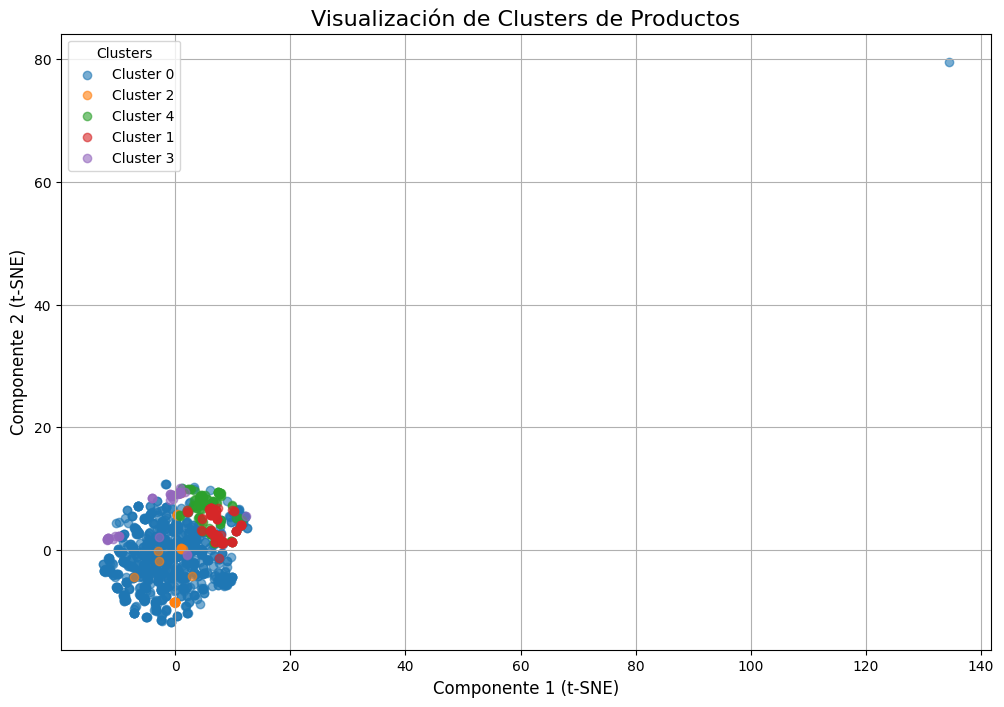

In [41]:
from sklearn.manifold import TSNE


# Reducir a 2D usando t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
reduced_features = tsne.fit_transform(tfidf_matrix.toarray())

# Crear un DataFrame con las coordenadas y los clusters
df_ancho2['x'] = reduced_features[:, 0]
df_ancho2['y'] = reduced_features[:, 1]

plt.figure(figsize=(12, 8))

for cluster in df_ancho2['cluster'].unique():
    cluster_data = df_ancho2[df_ancho2['cluster'] == cluster]
    plt.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {cluster}', alpha=0.6)

plt.title("Visualización de Clusters de Productos", fontsize=16)
plt.xlabel("Componente 1 (t-SNE)", fontsize=12)
plt.ylabel("Componente 2 (t-SNE)", fontsize=12)
plt.legend(title="Clusters", fontsize=10)
plt.grid(True)
plt.show()

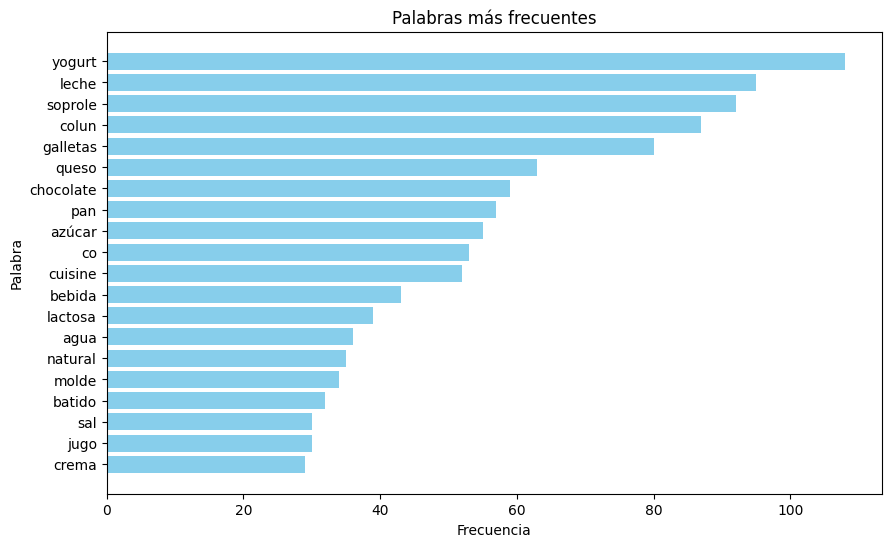

In [32]:
import re
from sklearn.feature_extraction.text import CountVectorizer

df_ancho2['nombre_producto_limpio'] = df_ancho2['nombre_producto'].str.lower().apply(lambda x: re.sub(r'[^a-záéíóúñ ]', '', x))

# Eliminamos stopwords básicas
stopwords = ['de', 'el', 'la', 'y', 'con', 'sin', 'por', 'para', 'a', 'en', 'del','&', 'un', 'kg', 'ml', 'envasado', 'pack', 'vainilla', 'light', 'cc', 'drenado', 'frutilla']  # Puedes ajustar la list
df_ancho2['nombre_producto_limpio'] = df_ancho2['nombre_producto_limpio'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stopwords])
)

# Tokenización y visualización de palabras más frecuentes
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_ancho2['nombre_producto_limpio'])
word_freq = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'frequency': X.sum(axis=0).A1})

# Ordenar por frecuencia
word_freq = word_freq.sort_values(by='frequency', ascending=False)


pd.set_option('display.max_rows', None)  # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.width', 10000)  # Aumenta el ancho del terminal




top_words = word_freq.head(20)

# Crear una gráfica de barras
plt.figure(figsize=(10, 6))
plt.barh(top_words['word'], top_words['frequency'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Palabras más frecuentes')
plt.gca().invert_yaxis()  # Invertir eje Y para que las palabras más frecuentes estén arriba
plt.show()